In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
sys.path.append("..")
import itertools
import time

import numpy as np

from santa.metrics import PerplexityCalculator
from santa.utils import save_text

/opt/mamba/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scorer = PerplexityCalculator("google/gemma-2-9b")

Loading checkpoint shards: 100% 8/8 [00:08<00:00,  1.09s/it]


In [3]:
target_id = 5
if target_id == 1:
    text      = "reindeer sleep walk the night and drive mistletoe scrooge laugh elf jump gingerbread bake ornament give family advent chimney fireplace"
    sub_texts = []
    fix_ids   = []
elif target_id == 2:
    text      = "sleigh yuletide beard carol cheer chimney decorations gifts grinch holiday holly jingle magi naughty nice nutcracker ornament polar workshop stocking"
    sub_texts = []
    fix_ids   = []
elif target_id == 3:
    text      = "sleigh of the magi yuletide cheer is unwrap gifts and eat cheer holiday decorations holly jingle relax sing carol visit workshop grinch naughty nice chimney stocking ornament nutcracker polar beard"
    sub_texts = []
    fix_ids   = [
        "sleigh of the magi yuletide cheer",
        "nutcracker polar beard",
        # "chimney stocking",
        # "grinch naughty",
        # "holly jingle",
        # "unwrap gifts"
        # "is unwrap gifts and eat cheer holiday decorations holly jingle relax sing carol visit workshop grinch naughty nice chimney stocking ornament nutcracker polar beard",
    ]
elif target_id == 4:
    text      = "the of and to in that have not you with we it from as peppermint candy fruitcake cookie chocolate milk eggnog greeting card wrapping paper bow toy doll game puzzle snowglobe candle fireplace wreath poinsettia angel star night wish dream believe wonder hope joy peace season merry hohoho kaggle workshop"
    sub_texts = [
        "candle fireplace wreath poinsettia angel star night wish dream", "from as peppermint candy fruitcake", "merry hohoho kaggle workshop",
        "the of and to in that", "card wrapping paper bow", "chocolate milk eggnog", "toy doll game puzzle", "hope joy peace season", 
    ]
    fix_ids   = [0]
elif target_id == 5:
    text      = "from and and the and of as in is it of that to the we the with you have advent card angel bake beard believe bow candy carol candle cheer cheer chocolate chimney chimney cookie decorations doll dream drive eat eggnog elf family fireplace fireplace fruitcake game gifts give gingerbread greeting grinch holiday holly hohoho hope jingle jump joy kaggle laugh magi merry milk mistletoe naughty nice night night not nutcracker ornament ornament paper peace peppermint polar poinsettia puzzle reindeer relax scrooge season sing sleigh sleep snowglobe star stocking toy unwrap visit walk wish wonder workshop workshop wrapping wreath yuletide"
    sub_texts = [
        "cookie decorations doll dream drive eat eggnog elf family fireplace fireplace fruitcake game gifts",
        "snowglobe star stocking toy unwrap visit walk wish wonder workshop workshop wrapping wreath yuletide",
        "kaggle laugh magi merry milk mistletoe naughty nice night night",
        "nutcracker ornament ornament paper peace peppermint",
        "puzzle reindeer relax scrooge season sing",
        "angel bake beard believe bow",
        # "we the with you have advent card angel bake beard believe bow candy carol candle cheer cheer chocolate chimney chimney cookie decorations doll dream drive eat eggnog elf family fireplace fireplace fruitcake game gifts give gingerbread greeting grinch holiday holly hohoho hope jingle jump joy kaggle laugh magi merry milk mistletoe naughty nice night night not nutcracker ornament ornament paper peace peppermint polar poinsettia puzzle reindeer relax scrooge season sing sleigh sleep snowglobe star stocking toy unwrap visit walk wish wonder workshop workshop wrapping wreath yuletide",
    ]
    fix_ids   = []

In [4]:
scorer.get_perplexity(text)

34.300373728940066

In [5]:
for st in sub_texts:
    text = text.replace(st, "-".join(st.split()))
text, len(text.split())

('from and and the and of as in is it of that to the we the with you have advent card angel-bake-beard-believe-bow candy carol candle cheer cheer chocolate chimney chimney cookie-decorations-doll-dream-drive-eat-eggnog-elf-family-fireplace-fireplace-fruitcake-game-gifts give gingerbread greeting grinch holiday holly hohoho hope jingle jump joy kaggle-laugh-magi-merry-milk-mistletoe-naughty-nice-night-night not nutcracker-ornament-ornament-paper-peace-peppermint polar poinsettia puzzle-reindeer-relax-scrooge-season-sing sleigh sleep snowglobe-star-stocking-toy-unwrap-visit-walk-wish-wonder-workshop-workshop-wrapping-wreath-yuletide',
 51)

In [6]:
tokens = text.split()
np.array(tokens)[fix_ids]

array([], dtype='<U100')

In [7]:
len(tokens) - len(fix_ids)

51

In [8]:
def tokens2text(tokens, sep="-"):
    return " ".join(tokens).replace(sep, " ")


def beam_search(init_tokens, fix_ids, scorer, k=30, precomputed={}, n_iters=100):
    n = len(init_tokens)
    candidates = [init_tokens]
    best_score = np.inf
    best_text = None
    top_solutions = {}
    for iterations in range(n_iters):
        start = time.time()
        solutions = {}
        for candidate in candidates:
            for i in range(n):
                if i in fix_ids:
                    continue
                for j in range(i+1, n):
                    if j in fix_ids:
                        continue
                    s = list(candidate).copy()
                    s[i], s[j] = s[j], s[i]
                    s = tuple(s)
                    if s in precomputed:
                        continue
                    text = tokens2text(s)
                    score = scorer.get_perplexity(text)
                    precomputed[s] = score
                    solutions[s] = score
        solutions = sorted(solutions.items(), key=lambda x: x[1])[:k]
        top_solutions.update(solutions)
        if len(solutions) == 0:
            break
        candidates, scores = map(list, zip(*solutions))
        if scores[0] < best_score:
            best_score = scores[0]
            best_text = tokens2text(candidates[0])
        print(f"[{iterations} iterations] best: {best_score:.3f}, current: {scores[0]:.3f}, top10 mean: {np.mean(scores[:10]):.3f}, elapsed time: {time.time()-start:.1f}[s]")
        print(tokens2text(candidates[0]))
    return best_score, best_text, top_solutions

In [9]:
%%time
best_score, best_text, top_solutions = beam_search(tokens, fix_ids, scorer, k=10, n_iters=20)

[0 iterations] best: 34.300, current: 34.300, top10 mean: 34.462, elapsed time: 97.6[s]
from and and the and of as in is it of that to the we the with you have advent card angel bake beard believe bow candy carol candle cheer cheer chocolate chimney chimney cookie decorations doll dream drive eat eggnog elf family fireplace fireplace fruitcake game gifts give gingerbread greeting grinch holiday holly hohoho hope jingle jump joy kaggle laugh magi merry milk mistletoe naughty nice night night not nutcracker ornament ornament paper peace peppermint polar poinsettia puzzle reindeer relax scrooge season sing sleigh sleep snowglobe star stocking toy unwrap visit walk wish wonder workshop workshop wrapping wreath yuletide
[1 iterations] best: 34.300, current: 34.300, top10 mean: 34.522, elapsed time: 873.7[s]
from and and the and of as in is it of that to the we the with you have advent card angel bake beard believe bow candy carol candle cheer cheer chocolate chimney chimney cookie decoratio

In [12]:
scorer.get_perplexity(best_text)

34.300373728940066

In [13]:
best_score

34.300373728940066

In [14]:
best_text

'from and and the and of as in is it of that to the we the with you have advent card angel bake beard believe bow candy carol candle cheer cheer chocolate chimney chimney cookie decorations doll dream drive eat eggnog elf family fireplace fireplace fruitcake game gifts give gingerbread greeting grinch holiday holly hohoho hope jingle jump joy kaggle laugh magi merry milk mistletoe naughty nice night night not nutcracker ornament ornament paper peace peppermint polar poinsettia puzzle reindeer relax scrooge season sing sleigh sleep snowglobe star stocking toy unwrap visit walk wish wonder workshop workshop wrapping wreath yuletide'

In [15]:
tmp = sorted(top_solutions.items(), key=lambda x: x[1])
candidates, scores = map(list, zip(*tmp))
candidates = [tokens2text(candidate) for candidate in candidates]

In [18]:
candidates[0]

'from and and the and of as in is it of that to the we the with you have advent card angel bake beard believe bow candy carol candle cheer cheer chocolate chimney chimney cookie decorations doll dream drive eat eggnog elf family fireplace fireplace fruitcake game gifts give gingerbread greeting grinch holiday holly hohoho hope jingle jump joy kaggle laugh magi merry milk mistletoe naughty nice night night not nutcracker ornament ornament paper peace peppermint polar poinsettia puzzle reindeer relax scrooge season sing sleigh sleep snowglobe star stocking toy unwrap visit walk wish wonder workshop workshop wrapping wreath yuletide'

In [19]:
candidates[1]

'from and and the and of as in is it of that to the we the with you have advent card angel bake beard believe bow candy carol candle cheer cheer chocolate chimney chimney cookie decorations doll dream drive eat eggnog elf family fireplace fireplace fruitcake game gifts give gingerbread greeting grinch holiday hope holly hohoho jingle jump joy kaggle laugh magi merry milk mistletoe naughty nice night night not nutcracker ornament ornament paper peace peppermint polar poinsettia puzzle reindeer relax scrooge season sing sleigh sleep snowglobe star stocking toy unwrap visit walk wish wonder workshop workshop wrapping wreath yuletide'

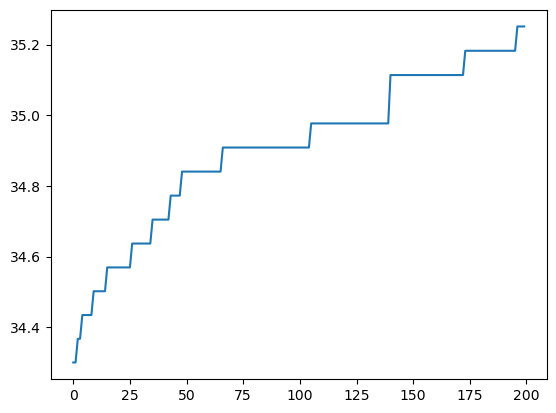

In [20]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(scores)), scores)

In [21]:
import math
from pathlib import Path

output_dir = "./output"
output_dir = Path(output_dir, f"id{target_id}")
output_dir.mkdir(parents=True, exist_ok=True)
for no, (text, score) in enumerate(zip(candidates, scores)):
    f, i = math.modf(score)
    i = int(i)
    f = int(f * 100000)
    with open(Path(output_dir, f"id{target_id}_{no:0>4}_{i:0>4}.{f}.txt"), "w") as f:
        f.write(text)

In [31]:
output_dir = "./output"
save_text(best_text, best_score, target_id, output_dir=output_dir)